# Avis Restau : improve the AI product of your start-up

## Context

"Avis Restau" is a start-up who's goal is to connect restaurants and customers. Customers will be able to post photos and reviews of the restaurants they have visited.

The goal here is to identify topics of bad customer reviews and to label photos as indoor or outdoor , food or drink, ...


## Load project modules

The helpers functions and project specific code will be placed in `../src/`.

We will use the [Python](https://www.python.org/about/gettingstarted/) programming language, and present here the code and results in this [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html) file.

We will use the usual libraries for data exploration, modeling and visualisation :

-   [NumPy](https://numpy.org/doc/stable/user/quickstart.html) and [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : for maths (stats, algebra, ...) and large data manipulation
-   [scikit-learn](https://scikit-learn.org/stable/getting_started.html) : for machine learning models training and evaluation
-   [Plotly](https://plotly.com/python/getting-started/) : for interactive data visualization

We will also use libraries specific to the goals of this project :

-   NLP Natural Language Processing
    -   [NLTK](https://www.nltk.org/) and [Spacy](https://spacy.io/api) : for text processing
    -   [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html) and [pyLDAvis](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) : for topic modelling and visualisation
-   CV Computer Visio
    -   [scikit-image](https://scikit-image.org/docs/stable/overview.html) and [OpenCV](https://docs.opencv.org/4.x/index.html) : for image processing
    -   [Keras](https://keras.io/getting_started/) : for neural network models training and evaluation


In [1]:
# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


# Set up logging
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)


# System modules
import random


# ML modules
import pandas as pd
import numpy as np


# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 10 * 1000  # <= 0 for all

In [2]:
# Download SpaCy model
!python -m spacy download en_core_web_sm

2021-12-12 16:39:00.282270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 16:39:00.282299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 9.4 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Yelp's API dataset

We will use Yelp's GraphQL API to get the data. We will load the Reviews (~3 reviews per restaurant) and Photos (1 photo per restaurant) of 1000 restaurants from 5 locations (200 restaurants per location).


### Download the dataset to CSV

We download the dataset from the Yelp GraphQL API.

In [3]:
# Download and unzip CSV files
!cd .. && make dataset && cd notebooks

>>> Downloading and saving data files...
python -m src.data.make-dataset -t data/raw/api/
INFO:root:Data already downloaded
>>> OK.



### Load the dataset from CSV

In [4]:
DATA_PATH = "../data/raw/api/"

businesses_csv_path = os.path.join(DATA_PATH, "businesses.csv")
reviews_csv_path = os.path.join(DATA_PATH, "reviews.csv")
photos_csv_path = os.path.join(DATA_PATH, "photos.csv")

if (
    os.path.exists(businesses_csv_path)
    and os.path.exists(reviews_csv_path)
    and os.path.exists(photos_csv_path)
):
    logging.info(f"Data found, loading from {DATA_PATH}")
    businesses_df = pd.read_csv(businesses_csv_path)
    reviews_df = pd.read_csv(reviews_csv_path)
    photos_df = pd.read_csv(photos_csv_path)
else:
    logging.error("Data not found, please run `make dataset`")

# Fix dtypes
businesses_df["business_alias"] = businesses_df["business_alias"].astype(str)
businesses_df["business_review_count"] = businesses_df["business_review_count"].astype(
    int
)
businesses_df["business_rating"] = businesses_df["business_rating"].astype(float)
businesses_df["business_price"] = businesses_df["business_price"].astype(int)
businesses_df["business_city"] = businesses_df["business_city"].astype(str)
businesses_df["business_state"] = businesses_df["business_state"].astype(str)
businesses_df["business_postal_code"] = businesses_df["business_postal_code"].astype(
    str
)
businesses_df["business_country"] = businesses_df["business_country"].astype(str)
businesses_df["business_latitude"] = businesses_df["business_latitude"].astype(float)
businesses_df["business_longitude"] = businesses_df["business_longitude"].astype(float)
businesses_df["business_categories"] = businesses_df["business_categories"].astype(str)
businesses_df["business_parent_categories"] = businesses_df[
    "business_parent_categories"
].astype(str)

reviews_df["business_alias"] = reviews_df["business_alias"].astype(str)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)
reviews_df["review_rating"] = reviews_df["review_rating"].astype(float)

photos_df["business_alias"] = photos_df["business_alias"].astype(str)
photos_df["photo_url"] = photos_df["photo_url"].astype(str)
photos_df["file_name"] = photos_df["file_name"].astype(str)

# Reduce memory usage
businesses_df = data_helpers.reduce_dataframe_memory_usage(businesses_df)
reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)

### Exploratory Data Analysis

We will just display here a few statistics about each DataFrame.

#### Businesses

The dataset is composed of 1000 businesses from 5 locations (Paris, New York, Tokyo, Rio de Janeiro and Sydney). Each business has a unique ID, a name, a category, an average rating, a price category, a city, a state, a country, a postal code, a latitude and a longitude.


In [5]:
businesses_df.head()

business_alias  business_review_count  \
0  le-comptoir-de-la-gastronomie-paris                   1107   
1               l-as-du-fallafel-paris                   1810   
2                       angelina-paris                   1347   
3             l-avant-comptoir-paris-3                    612   
4               la-coïncidence-paris-4                    493   

   business_rating  business_price business_city business_state  \
0              4.5               2         Paris             75   
1              4.5               1         Paris             75   
2              4.0               3         Paris             75   
3              4.5               2         Paris             75   
4              4.5               2         Paris             75   

  business_postal_code business_country  business_latitude  \
0                75001               FR          48.864517   
1                75004               FR          48.857498   
2                75001               FR          48.865093   
3                75006               FR          48.852020   
4                75116               FR          48.868107   

   business_longitude                      business_categories  \
0            2.345402                               ["french"]   
1            2.359080      ["kosher", "falafel", "sandwiches"]   
2            2.328464  ["tea", "cakeshop", "breakfast_brunch"]   
3            2.338800                   ["wine_bars", "tapas"]   
4            2.284365                               ["french"]   

         business_parent_categories  
0                   ["restaurants"]  
1  ["restaurants", "mediterranean"]  
2           ["restaurants", "food"]  
3           ["bars", "restaurants"]  
4                   ["restaurants"]

In [6]:
businesses_df.describe(include="all")

business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude business_categories business_parent_categories  
count          1000.000000                1000                       1000  
unique                 NaN                 530                         50  
top                    NaN          ["french"]            ["restaurants"]  
freq                   NaN                  56                        551  
mean             35.219700                 NaN                        NaN  
std              93.358452                 NaN                        NaN  
min             -74.016022                 NaN                        NaN  
25%             -43.218462                 NaN                        NaN  
50%               2.340317                 NaN                        NaN  
75%             139.770420                 NaN                        NaN  
max             151.298248                 NaN                        NaN

In [7]:
fig = px.histogram(
    businesses_df, x="business_rating", marginal="box", color="business_country"
)
fig.show()

In [8]:
fig = px.histogram(
    businesses_df, x="business_price", marginal="box", color="business_country"
)
fig.show()

We can see that French and Japanese restaurants have higher review ratings, but Japanese restaurants are less expensive than french ones.

There are no empty values or outliers.


In [9]:
# Encode categories
df = feat_helpers.one_hot_encode_list_variables(
    businesses_df, ["business_categories", "business_parent_categories"]
)

In [10]:
# Plot the correlation of categories with rating
corr_rating = (
    df[
        ["business_rating", "business_price"]
        + [col for col in df.columns if col.startswith("business_categories")]
    ]
    .corr()[["business_rating"]]
    .drop("business_rating")
    .sort_values(
        by=["business_rating"],
        ascending=False,
    )
)


fig = px.bar(corr_rating.head(10).append(corr_rating.tail(10)), color="value")
fig.update_layout(
    title="Top 20 Correlations with Business Rating",
    xaxis_title="Category",
    yaxis_title="Correlation",
)
fig.show()

In [11]:
# Plot the correlation of categories with prince
corr_price = (
    df[
        ["business_price", "business_rating"]
        + [col for col in df.columns if col.startswith("business_categories")]
    ]
    .corr()[["business_price"]]
    .drop("business_price")
    .sort_values(
        by=["business_price"],
        ascending=False,
    )
)


fig = px.bar(corr_price.head(10).append(corr_price.tail(10)), color="value")
fig.update_layout(
    title="Top 20 Correlations with Business Price",
    xaxis_title="Category",
    yaxis_title="Correlation",
)
fig.show()

Overall, pricy restaurants tend to have lower review ratings : people are more picky when they spend more money.
The correlations confirm that French restaurants are overpriced (high positive correlation to the Price), while Japanese restaurants are cheap (high negative correlation to the Price). Ramen restaurants seem to be the best value for money deals (un the top 10 Ratings and bottom 10 Prices).


#### Reviews

The dataset is composed of 2928 reviews from 1000 businesses (~3 reviews per business). Each review has a business alias, a text and a rating.


In [12]:
reviews_df.head()

business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1  le-comptoir-de-la-gastronomie-paris   
2  le-comptoir-de-la-gastronomie-paris   
3               l-as-du-fallafel-paris   
4               l-as-du-fallafel-paris   

                                         review_text  review_rating  
0  This review is from our 2019 trip.  Shame on m...            5.0  
1  This place def lives up the hype.  Best French...            5.0  
2  While planning a friends trip to Paris, I came...            5.0  
3  This is the best falafel sandwich I have ever ...            5.0  
4  IMO this is a must try in Paris. 

Located in ...            5.0

In [13]:
reviews_df.describe(include="all")

business_alias  \
count                                  2928   
unique                                  990   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      3   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

                                              review_text  review_rating  
count                                                2928    2928.000000  
unique                                               2928            NaN  
top     This review is from our 2019 trip.  Shame on m...            NaN  
freq                                                    1            NaN  
mean                                                  NaN       4.396516  
std                                                   NaN       0.904879  
min                                                   NaN       1.000000  
25%                                                   NaN       4.000000  
50%                                                   NaN       5.000000  
75%                                                   NaN       5.000000  
max                                                   NaN       5.000000

In [14]:
reviews_text_df = pd.DataFrame()
reviews_text_df["len"] = reviews_df["review_text"].str.len()
reviews_text_df["wc"] = reviews_df["review_text"].str.split().str.len()

fig = px.histogram(reviews_text_df, x="len", marginal="box", title="Review Text Length")
fig.show()

fig = px.histogram(
    reviews_text_df, x="wc", marginal="box", title="Review Text Word Count"
)
fig.show()

In [15]:
fig = px.histogram(
    reviews_df, x="review_rating", marginal="box", title="Review Ratings"
)
fig.show()

Reviews are truncated to 160 characters (~30 words per review). This can be a problem when the text that would explain the review rating has been removed.

We can see that review ratings are highly skewed towards the high grades : more than half of the reviews are 5 stars.

There are no empty values or outliers.


In [16]:
ratings_diff = reviews_df.join(
    businesses_df.set_index("business_alias")[["business_rating"]],
    on="business_alias",
)
reviews_df["rating_diff"] = (
    ratings_diff["review_rating"] - ratings_diff["business_rating"]
)
reviews_df["rating_sentiment"] = (reviews_df["rating_diff"] > 0).astype(int)


reviews_df[["rating_diff", "rating_sentiment"]].describe()

rating_diff  rating_sentiment
count  2928.000000       2928.000000
mean      0.125683          0.572404
std       0.875052          0.494814
min      -3.500000          0.000000
25%      -0.500000          0.000000
50%       0.500000          1.000000
75%       0.500000          1.000000
max       2.000000          1.000000

In [17]:
fig = px.histogram(
    reviews_df,
    x="rating_diff",
    marginal="box",
    title="Rating Difference : Review ratings - Business average ratings",
    color=reviews_df["rating_sentiment"],
)
fig.show()

We can see that in our Reviews dataset, ratings are a bit higher than the average ratings from the Businesses dataset.

For the rest of this analysis, we will consider the difference of rating between a review and the average rating of the business. A review is considered as a positive review if the rating is higher than the average rating of the business, and a negative review if the rating is lower or equal to the average rating of the business.


#### Photos

The dataset is composed of 999 photos from 1000 businesses (~1 photo per business). Each photo has a business alias and a photo URL.


In [18]:
photos_df.head()

business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1               l-as-du-fallafel-paris   
2                       angelina-paris   
3             l-avant-comptoir-paris-3   
4               la-coïncidence-paris-4   

                                           photo_url  \
0  https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...   
1  https://s3-media2.fl.yelpcdn.com/bphoto/wdIhzK...   
2  https://s3-media3.fl.yelpcdn.com/bphoto/DPM5TB...   
3  https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxg...   
4  https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgE...   

                                           file_name  
0  le-comptoir-de-la-gastronomie-paris_0200c0c54c...  
1  l-as-du-fallafel-paris_ab3344d5839c2238e825b28...  
2  angelina-paris_0aced3805db4ea7246d49c771fc48d8...  
3  l-avant-comptoir-paris-3_73670e8469e59d89b41bf...  
4  la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb...

In [19]:
photos_df.describe(include="all")

business_alias  \
count                                   999   
unique                                  999   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      1   

                                                photo_url  \
count                                                 999   
unique                                                999   
top     https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...   
freq                                                    1   

                                                file_name  
count                                                 999  
unique                                                999  
top     le-comptoir-de-la-gastronomie-paris_0200c0c54c...  
freq                                                    1

We will study the photos more deeply in the dedicated section.

## Academic dataset

We will use also use the Academic dataset provided by Yelp (https://www.yelp.com/dataset) composed of 8,635,403 reviews, 160,585 businesses and 200,000 pictures from 8 metropolitan areas.

We are only going to use the reviews and photos data. Since the dataset is huge, we are going to sample a small subset of the data.


### Load the dataset from JSON


In [20]:
# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all

# Load academic dataset
if os.path.exists("../data/processed/academic/reviews.pkl.gz"):
    # Load academic data from pickle file
    logger.info(">>> Loading reviews from pickle file...")
    reviews_academic_df = pd.read_pickle("../data/processed/academic/reviews.pkl.gz")
    logger.info(f">>> OK : {len(reviews_academic_df)} reviews loaded from pickle file.")
else:
    # Load academic data from row CSV file
    logger.info(">>> Loading reviews from JSON file...")
    reviews_academic_df = pd.DataFrame()
    with pd.read_json(
        "../data/raw/academic/yelp_academic_dataset_review.json",
        dtype={
            "review_id": str,
            "user_id": str,
            "business_id": str,
            "stars": int,
            "useful": int,
            "funny": int,
            "cool": int,
            "text": str,
            "date": "datetime64[ns]",
        },
        chunksize=500 * 1000,
        lines=True,
    ) as json_reader:
        # Load data in chunks
        for chunk in json_reader:
            reviews_academic_df = reviews_academic_df.append(chunk)
            logger.info(f"Loaded {len(reviews_academic_df)} reviews")
    logger.info(f">>> OK : {len(reviews_academic_df)} reviews loaded from JSON file.")

    # Reduce memory usage
    reviews_academic_df = data_helpers.reduce_dataframe_memory_usage(
        reviews_academic_df
    )

    # Save as pickle
    logger.info(">>> Saving reviews data as pickle file...")
    os.makedirs("../data/processed/academic/", exist_ok=True)
    reviews_academic_df.to_pickle("../data/processed/academic/reviews.pkl.gz")
    logger.info(
        ">>> OK : Reviews data saved to ../data/processed/academic/reviews.pkl.gz ."
    )

if TEXT_SAMPLE_SIZE > 0:
    # Sample data
    logger.info(">>> Sampling reviews data...")
    reviews_academic_df = reviews_academic_df.sample(TEXT_SAMPLE_SIZE, random_state=42)
    logger.info(f">>> OK : Data sampled to {len(reviews_academic_df)} reviews.")

### Exploratory Data Analysis

We will just display here a few statistics about each DataFrame.

In [21]:
reviews_academic_df.describe(include="all", datetime_is_numeric=True)

review_id                 user_id  \
count                    10000                   10000   
unique                   10000                    9726   
top     8W--5RJuDQbsTjiKJaho7A  RtGqdDBvvBCjcu5dUqwfzA   
freq                         1                       9   
mean                       NaN                     NaN   
std                        NaN                     NaN   
min                        NaN                     NaN   
25%                        NaN                     NaN   
50%                        NaN                     NaN   
75%                        NaN                     NaN   
max                        NaN                     NaN   

                   business_id         stars        useful         funny  \
count                    10000  10000.000000  10000.000000  10000.000000   
unique                    8479           NaN           NaN           NaN   
top     WkN8Z2Q8gbhjjkCt8cDVxg           NaN           NaN           NaN   
freq                        11           NaN           NaN           NaN   
mean                       NaN      3.728400      1.260800      0.407000   
std                        NaN      1.465554      3.214843      1.874594   
min                        NaN      1.000000      0.000000      0.000000   
25%                        NaN      3.000000      0.000000      0.000000   
50%                        NaN      4.000000      0.000000      0.000000   
75%                        NaN      5.000000      1.000000      0.000000   
max                        NaN      5.000000    123.000000    100.000000   

                cool                                               text  \
count   10000.000000                                              10000   
unique           NaN                                              10000   
top              NaN  Most fave place to get live seafood. Been a cu...   
freq             NaN                                                  1   
mean        0.499600                                                NaN   
std         2.279324                                                NaN   
min         0.000000                                                NaN   
25%         0.000000                                                NaN   
50%         0.000000                                                NaN   
75%         0.000000                                                NaN   
max       124.000000                                                NaN   

                       date  
count                 10000  
unique                10000  
top     2014-09-13 09:43:57  
freq                      1  
mean                    NaN  
std                     NaN  
min                     NaN  
25%                     NaN  
50%                     NaN  
75%                     NaN  
max                     NaN

In [22]:
# Number of reviews per user
reviews_per_user = reviews_academic_df.groupby("user_id").count()["review_id"]

fig = px.histogram(
    reviews_per_user,
    title=f"Number of reviews per user (N={len(reviews_academic_df)})",
    log_y=True,
    histnorm="probability density",
)
fig.update_layout(
    xaxis_title_text="Number of reviews",
    yaxis_title_text="Ratio of users (log)",
)
fig.show()

Most users (~98%) write only one review.

In [23]:
# Number of reviews per business
reviews_per_business = reviews_academic_df.groupby("business_id").count()["review_id"]

fig = px.histogram(
    reviews_per_business,
    title=f"Number of reviews per business (N={len(reviews_academic_df)})",
    log_y=True,
    histnorm="probability density",
)
fig.update_layout(
    xaxis_title_text="Number of reviews",
    yaxis_title_text="Ratio of businesses (log)",
)
fig.show()

Most businesses (~87%) have only one review.

In [24]:
# Number of reviews per stars
fig = px.histogram(
    reviews_academic_df.sample(1000, random_state=42),
    x="stars",
    title=f"Reviews by Stars (N={len(reviews_academic_df)}, n=1000)",
    marginal="box",
    histnorm="probability",
)
fig.show()

The stars distribution is quite similar to the API dataset: half of the reviews are 5 stars. But there are more 3 and 2 stars reviews and much more 1 star reviews. This shows that one of the two datasets is not representative of the reality.


In [25]:
# Number of reviews per reaction
fig = px.histogram(
    reviews_academic_df[["useful", "funny", "cool"]],
    title=f"Useful / Funny / Cool score per review (N={len(reviews_academic_df)})",
    log_y=True,
    histnorm="probability density",
    barmode="stack",
)
fig.update_layout(
    xaxis_title_text="Useful / Funny / Cool score",
    yaxis_title_text="Ratio of reviews (log)",
)
fig.show()

We can see that the Academic dataset is a bit different that the API dataset. : 
- there are far more reviews and photos
- reviews are not truncated
- each review has reactions ("useful", "funny", "cool")
- stars are better distributed

## Natural Language Processing (NLP) : analysis of the reviews texts

In this section, we are going to try and identify the topics of bad reviews.
To achieve this, we are going to represent the reviews as a bag of words (BoW) and to use a topic modelling algorithm to identify the topics of the reviews.
We are going to compare different text processing techniques and to compare the results of topic modelling algorithms.


### Build the dataset and define the models

We are going to use a target variable for regression (rating difference) and a target variable for classification (review sentiment).


In [26]:
from sklearn.model_selection import train_test_split


## API dataset

# Sentiment analysis : regression of rating difference
X = reviews_df["review_text"]
y = reviews_df["rating_diff"]

# Free memory
del reviews_df

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Sentiment analysis : binary classification
y_bi = (y > 0).astype(int)
y_train_bi = (y_train > 0).astype(int)
y_test_bi = (y_test > 0).astype(int)


## Academic dataset

X_academic = reviews_academic_df["text"]
y_academic = reviews_academic_df["stars"]

# Free memory
del reviews_academic_df

We are going to compare different combinations of text tokenizers and vectorizers. The goal here is to eliminate the noise of the reviews and to reduce the dimension of the dataset, while trying to keep the meaning of the reviews.

**Vectorizer** : transforms a list of tokens into a vector of features, with more or less processing of the tokens

-   `CountVectorizer` : just count the token occurrences in each document of the corpus
-   `TfidfVectorizer` : count the token occurrences in each document of the corpus and then compute the inverse document frequency (IDF) of each token (if a token is present in every document, it is not specific to a document and its IDF will be low)
-   `strip_accents` : replace special characters
-   `lowercase` : transform all the tokens to lowercase
-   `stop_words` : remove tokens thet belong to a list of stopwords (ex. : "the", "a", "of", ...)
-   `{min,max}_df` : filter out tokens that appear in less than min_df documents or more than max_df documents to prevent the feature to be too specific or too general
-   `ngrams` : create n-grams from the tokens, i.e. create combinations of n consecutive tokens

**Tokenizer** : transforms a string of text into a list of tokens, with more or less processing of the text

-   `None` : no text processing, just split the string into words (default)
-   `PorterStemmer` : *stemming* is the process of removing prefixes or suffixes of words (ex. : "ing", "ed", "ly", ...) to prevent same token variations (ex. : "running", "run", "runs", ...)
-   `WordNetLemmatizer` : *lemmatization* is the process of changing the word into its base form (ex. : "running" -> "run", "runs" -> "run", ...)
-   `SpaCy` : SpaCy is a library for natural language processing (NLP) that uses a combination of machine learning, natural language understanding, and natural language generation


In [27]:
# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tokenizers, Stemmers and Lemmatizers
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


# PoS (Part of Speach) tagger
def pos_tagger(nltk_tag: str) -> str:
    """
    Translate NLTK POS tags to spacy POS tags.

    Args:
        nltk_tag (str): NLTK POS tag.

    Returns:
        str: Spacy POS tag.
    """
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# Tokenizers : simple to complex
tokenizers = {
    "None": None,  # basic word tokenizer
    "stopwords": lambda text: [  # remove stopwords
        token.lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "PorterStemmer": lambda text: [  # Porter Stemmer
        PorterStemmer().stem(token).lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "WordNetLemmatizer": lambda text: [  # WordNet Lemmatizer
        WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
        for token, pos in pos_tag(word_tokenize(text))
        if token.isalpha() and token.lower() not in stopwords
    ],
    "SpaCy": lambda text: [  # SpaCy Lemmatizer
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ],
}

# Basic vectorizers : simple tokenization, no stemming or lemmatization
vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
    "CountVectorizer + strip_accents + lowercase": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "TfidfVectorizer + strip_accents + lowercase": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
}

# Enrich vectorizers with more complex tokenizers : stemming and lemmatization
for tokenizer_name, tokenizer in tokenizers.items():
    vectorizers[
        f"CountVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )
    vectorizers[
        f"TfidfVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )

2021-12-12 16:40:00.090033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 16:40:00.090059: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Regression models evaluation

We are going to evaluate the combination of different tokenizers, vectorizers and regression models in order to find the model that best predicts the sentiment of the reviews (as the difference between the Business' average rating and the review rating).


In [28]:
# Regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    PassiveAggressiveRegressor,
    SGDRegressor,
    Ridge,
    RidgeCV,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV,
    LassoLars,
    LassoLarsCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    BayesianRidge,
    ARDRegression,
    HuberRegressor,
    TheilSenRegressor,
    PassiveAggressiveRegressor,
    SGDRegressor,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor


if not os.path.exists("../results/regressors_grid_search_results.csv"):
    # Define a processing pipeline : vectorizer + regressor
    pipe_reg = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("reg", DummyRegressor()),
        ]
    )

    # Define a grid search : vectorizer + regressor + hyperparameters
    grid_reg = GridSearchCV(
        pipe_reg,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            reg=[
                DummyRegressor(),
                ElasticNetCV(cv=2),
                # TransformedTargetRegressor(
                #     regressor=ElasticNetCV(),
                #     transformer=QuantileTransformer(),
                # ),
                LinearRegression(),
                # RidgeCV(cv=2),
                # LarsCV(),
                # LassoCV(cv=2),
                # LassoLars(),
                # LassoLarsCV(),
                # OrthogonalMatchingPursuit(),
                # OrthogonalMatchingPursuitCV(),
                # BayesianRidge(),
                # ARDRegression(),
                # HuberRegressor(),
                # TheilSenRegressor(),
                # PassiveAggressiveRegressor(),
                # SGDRegressor(),
                # KernelRidge(),
                SVR(),
                MLPRegressor(),
                # KNeighborsRegressor(),
                # DecisionTreeRegressor(),
                RandomForestRegressor(),
                # GradientBoostingRegressor(),
                LGBMRegressor(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        # verbose=9,
    ).fit(X, y)

    print(grid_reg.best_estimator_)
    print(grid_reg.best_params_)
    print(grid_reg.best_score_)

    with open("../results/regressors_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_reg.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/regressors_grid_search_results.csv", index=False)

else:
    results_reg_df = pd.read_csv("../results/regressors_grid_search_results.csv")
    print(
        results_reg_df[
            [
                "param_reg",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )

              param_reg                                          param_vec  \
0    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
1    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
2    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
3    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
4    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
..                  ...                                                ...   
555     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
556     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
557     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
558     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
559     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0       

It appears that the best regression model is the `ElasticNetCV` model, which outperforms all other models, whatever the tokenizer and vectorizer.

A surprizing result is that the more complex vectorizers and tokenizers don't really improve the results. This might be due to the fact that the dataset is quite small and the reviews are quite similar.


### Classification models evaluation

We are going to evaluate the combination of different tokenizers, vectorizers and classification models in order to find the model that best predicts the sentiment of the reviews (as whether the review rating is higher ("good" review) or lower ("bad" review) than the Business' average rating).


In [29]:
# Classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier


if not os.path.exists("../results/classifiers_grid_search_results.csv"):
    # Define a processing pipeline : vectorizer + classifier
    pipe_cls = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("cls", DummyClassifier()),
        ]
    )

    # Define a grid search : vectorizer + classifier + hyperparameters
    grid_cls = GridSearchCV(
        pipe_cls,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            cls=[
                DummyClassifier(),
                RidgeClassifierCV(cv=2),
                LogisticRegressionCV(cv=2),
                # SGDClassifier(),
                SVC(),
                KNeighborsClassifier(),
                MLPClassifier(),
                # DecisionTreeClassifier(),
                RandomForestClassifier(),
                # GradientBoostingClassifier(),
                LGBMClassifier(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        # verbose=9,
    ).fit(X, y_bi)

    print(grid_cls.best_estimator_)
    print(grid_cls.best_params_)
    print(grid_cls.best_score_)

    with open("../results/classifiers_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_cls.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/classifiers_grid_search_results.csv", index=False)

else:
    results_cls_df = pd.read_csv("../results/classifiers_grid_search_results.csv")
    print(
        results_cls_df[
            [
                "param_cls",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )

                      param_cls                                 param_vec  \
0                         SVC()  CountVectorizer(strip_accents='unicode')   
1                         SVC()  CountVectorizer(strip_accents='unicode')   
2    LogisticRegressionCV(cv=2)  CountVectorizer(strip_accents='unicode')   
3    LogisticRegressionCV(cv=2)  CountVectorizer(strip_accents='unicode')   
4                         SVC()  CountVectorizer(strip_accents='unicode')   
..                          ...                                       ...   
635            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
636            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
637            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
638            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
639            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0         0.481287  

It appears that the best regression model is the `SVC` model. The `LogisticRegressionCV`, `RandomForestClassifier` and `RidgeClassifierCV` have similar results depending on the tokenizer and vectorizer.

Again, the more complex text processors don't necessarily improve the results.


### Vectorizer and tokenizer models comparison

Now that we have found the best Machine Learning models for regression and classification, we are going to compare the results of the different vectorizers and tokenizers. We will use the same dataset and the same regression and classification models.

The goal is to measure the influence of the different vectorizers and tokenizers on the results of the regression and classification models. We also want to evaluate (empirically) how the vectorizers and tokenizers improve the interpretability of the models.


In [30]:
from sklearn.linear_model import ElasticNetCV  # Regression
from sklearn.linear_model import RidgeClassifierCV  # Classification

from sklearn.metrics import (
    # Regression metrics
    median_absolute_error,
    r2_score,
    # Classification metrics
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
)


if not os.path.exists(
    "../results/regression_vectorisers_results.csv"
) or not os.path.exists("../results/classification_vectorisers_results.csv"):
    results_reg = []
    results_cls = []

    for vectorizer_name, vectorizer in vectorizers.items():
        # Vectorization of the corpus
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        # Tokens distribution
        words_count = pd.Series(
            X_train_vec.sum(axis=0).tolist()[0],
            index=vectorizer.get_feature_names_out(),
        )

        # Top 20 tokens by occurrences
        top_20_count = words_count.sort_values(ascending=False).head(20)

        fig = px.bar(
            top_20_count,
            x=top_20_count.index,
            y=top_20_count.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_count.values,
        )
        fig.show()

        # Regression model
        print("Regression")

        # Train the regression model
        reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)

        # Comute the coefficients
        coefs_reg = pd.Series(reg.coef_, index=vectorizer.get_feature_names_out())

        # Top 20 tokens by importance (positive and negative)
        top_20_coefs_reg = (
            coefs_reg.nlargest(10).append(coefs_reg.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_reg,
            x=top_20_coefs_reg.index,
            y=top_20_coefs_reg.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_reg.values,
        )
        fig.show()

        # Test the regression model
        y_pred_reg = reg.predict(X_test_vec)

        fig = px.box(
            x=y_test,
            y=y_pred_reg,
            labels={"x": "Actual", "y": "Predicted"},
            title=f"{vectorizer_name} : Actual vs Predicted / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}",
            color=y_test,
        )
        fig.show()

        # Keep the results
        results_reg.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "r2_score": r2_score(y_test, y_pred_reg),
                "median_absolute_error": median_absolute_error(y_test, y_pred_reg),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}"
        )
        print()

        # Classification model
        print("Classification")

        # Train the regression model
        cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)

        # Comute the coefficients
        coefs_cls = pd.Series(
            cls.coef_[0],
            index=vectorizer.get_feature_names_out(),
        )

        # Top 20 tokens by importance (positive and negative)
        top_20_coefs_cls = (
            coefs_cls.nlargest(10).append(coefs_cls.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_cls,
            x=top_20_coefs_cls.index,
            y=top_20_coefs_cls.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_cls.values,
        )
        fig.show()

        # Test the regression model
        y_pred_cls = cls.predict(X_test_vec)

        plot_confusion_matrix(
            estimator=cls,
            X=X_test_vec,
            y_true=y_test_bi,
        )
        plt.show()

        plot_roc_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        plot_precision_recall_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        # Keep the results
        results_cls.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "accuracy_score": accuracy_score(y_test_bi, y_pred_cls),
                "precision_score": precision_score(y_test_bi, y_pred_cls),
                "recall_score": recall_score(y_test_bi, y_pred_cls),
                "f1_score": f1_score(y_test_bi, y_pred_cls),
                "roc_auc_score": roc_auc_score(y_test_bi, y_pred_cls),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / accuracy_score = {round(accuracy_score(y_test_bi, y_pred_cls), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred_cls), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred_cls), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred_cls), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred_cls), 3)}"
        )
        print()

    print(
        pd.DataFrame(results_reg).sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    with open("../results/regression_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_reg)
            .sort_values(
                by=["r2_score", "median_absolute_error"],
                ascending=[False, True],
            )
            .to_csv(index=False)
        )

    print(
        pd.DataFrame(results_cls).sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )

    with open("../results/classification_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_cls)
            .sort_values(
                by=["roc_auc_score", "f1_score"],
                ascending=[False, False],
            )
            .to_csv(index=False)
        )

else:
    results_reg_df = pd.read_csv("../results/regression_vectorisers_results.csv")
    print(
        results_reg_df.sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    results_cls_df = pd.read_csv("../results/classification_vectorisers_results.csv")
    print(
        results_cls_df.sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )

                                           vectorizer  vocabulary_size  \
0                                     TfidfVectorizer             5541   
1         TfidfVectorizer + strip_accents + lowercase             5523   
2                                     CountVectorizer             5541   
3         CountVectorizer + strip_accents + lowercase             5523   
4   TfidfVectorizer + strip_accents + lowercase + ...             5389   
5   CountVectorizer + strip_accents + lowercase + ...             5389   
6   CountVectorizer + strip_accents + lowercase + ...              546   
7   TfidfVectorizer + strip_accents + lowercase + ...              546   
8   CountVectorizer + strip_accents + lowercase + ...              294   
9   TfidfVectorizer + strip_accents + lowercase + ...              294   
10  CountVectorizer + strip_accents + lowercase + ...              248   
11  CountVectorizer + strip_accents + lowercase + ...              286   
12  TfidfVectorizer + strip_accents + 

As we can see, the best text processing models both for regression and classification are the most simple ones (basic `CountVectorizer` and `TfidfVectorizer`). Adding complexity to the text processing models doesn't improve the results, but they greatly help reduce the vocabulary size and make sense of the importance of each word to estimate the sentiment of a review.

With these results, we are able to visualize "negative words" (like "bad", "worst", "disappoining", "rude", ...) and "positive words" (like "amazing", "favorite", "delicious", "wonderful", ...) in the reviews.


#### Test our best models

We are going to test the best regression and classification models on a random review from the test dataset, and compare the prediction with a pre-trained model.


In [31]:
from sklearn.linear_model import ElasticNetCV, RidgeClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer


# Define the vectorizer
vectorizer = vectorizers[
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy"
]

# Vectorization of the corpus
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the regression model
reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)

# Test the regression model
y_pred_reg = reg.predict(X_test_vec)

# Train the regression model
cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)

# Test the regression model
y_pred_cls = cls.predict(X_test_vec)

In [32]:
# Pick a random review for testing
rand_index = random.randint(0, len(X_test))
review_text = X_test.values[rand_index]
true_reg = y_test.values[rand_index]
pred_reg = y_pred_reg[rand_index]
true_cls = y_test_bi.values[rand_index]
pred_cls = y_pred_cls[rand_index]

# Display the review text
print(f'Review : "{review_text}"')

# Display the predicted rating and sentiment
if abs(true_reg - pred_reg) < 1:
    print(
        f"✅ Predicted review rating correct : {pred_reg} (pred) vs. {true_reg} (true)"
    )
else:
    print(
        f"❌ Predicted review rating incorrect : {pred_reg} (pred) vs. {true_reg} (true)"
    )

if true_cls == pred_cls:
    print(
        f"✅ Predicted review sentiment correct : {pred_cls} (pred) vs. {true_cls} (true)"
    )
else:
    print(
        f"❌ Predicted review sentiment incorrect : {pred_cls} (pred) vs. {true_cls} (true)"
    )

Review : "Everyone said this place was great so we had to check it out. We arrived shortly after 7pm on a Sunday night and already the place was packed. We rested on..."
❌ Predicted review rating incorrect : 0.1493293781647798 (pred) vs. -1.5 (true)
❌ Predicted review sentiment incorrect : 1 (pred) vs. 0 (true)


We can see that our model is not very good, but is already able to make better predictions than a random guess, despite the very small training dataset with a lot of missing information due to truncated text.

Let's see how a pre-trained model performs on the same review.

In [33]:
import transformers
import shap


# print the JS visualization code to the notebook
shap.initjs()

# load a transformers pipeline model
model = transformers.pipeline("sentiment-analysis", return_all_scores=True)
result = model([review_text])

# explain the model on two sample inputs
explainer = shap.Explainer(model)
shap_values = explainer([review_text])
pred = int(
    (result[0][0]["label"] == "POSITIVE" and result[0][0]["score"] > 0.5)
    or (result[0][0]["label"] == "NEGATIVE" and result[0][0]["score"] < 0.5)
)

# Display the predicted rating and sentiment
if true_cls == pred:
    print(f"✅ Predicted review sentiment correct : {pred} (pred) vs. {true_cls} (true)")
else:
    print(
        f"❌ Predicted review sentiment incorrect : {pred} (pred) vs. {true_cls} (true)"
    )

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
                                                   

❌ Predicted review sentiment incorrect : 1 (pred) vs. 0 (true)


We can see that the pre-trained model is able to make better predictions than our model, but can also be tricked by the poor data.


### Topic Modeling

We want to be able to identify the topics of the reviews in order to understand why clients were satisfied or not.

We are going to use two different techniques to identify the topics of the reviews :

-   `LSA` : Latent Semantic Analysis (LSA) is a method for dimensionality reduction. It is a supervised method that uses a matrix decomposition to project the data into a lower dimensional space.
-   `LDA` : Latent Dirichlet Allocation (LDA) is a probabilistic model that uses a probabilistic graphical model to infer the topic distribution of a document.


#### Latent Semantic Analysis (LSA)

We are going to use the Latent Semantic Analysis (LSA) technique to identify the topics of the reviews.

We are going to compare the results of the different vectorizers and tokenizers.


##### API dataset

First, let's compare the topics on the API dataset.

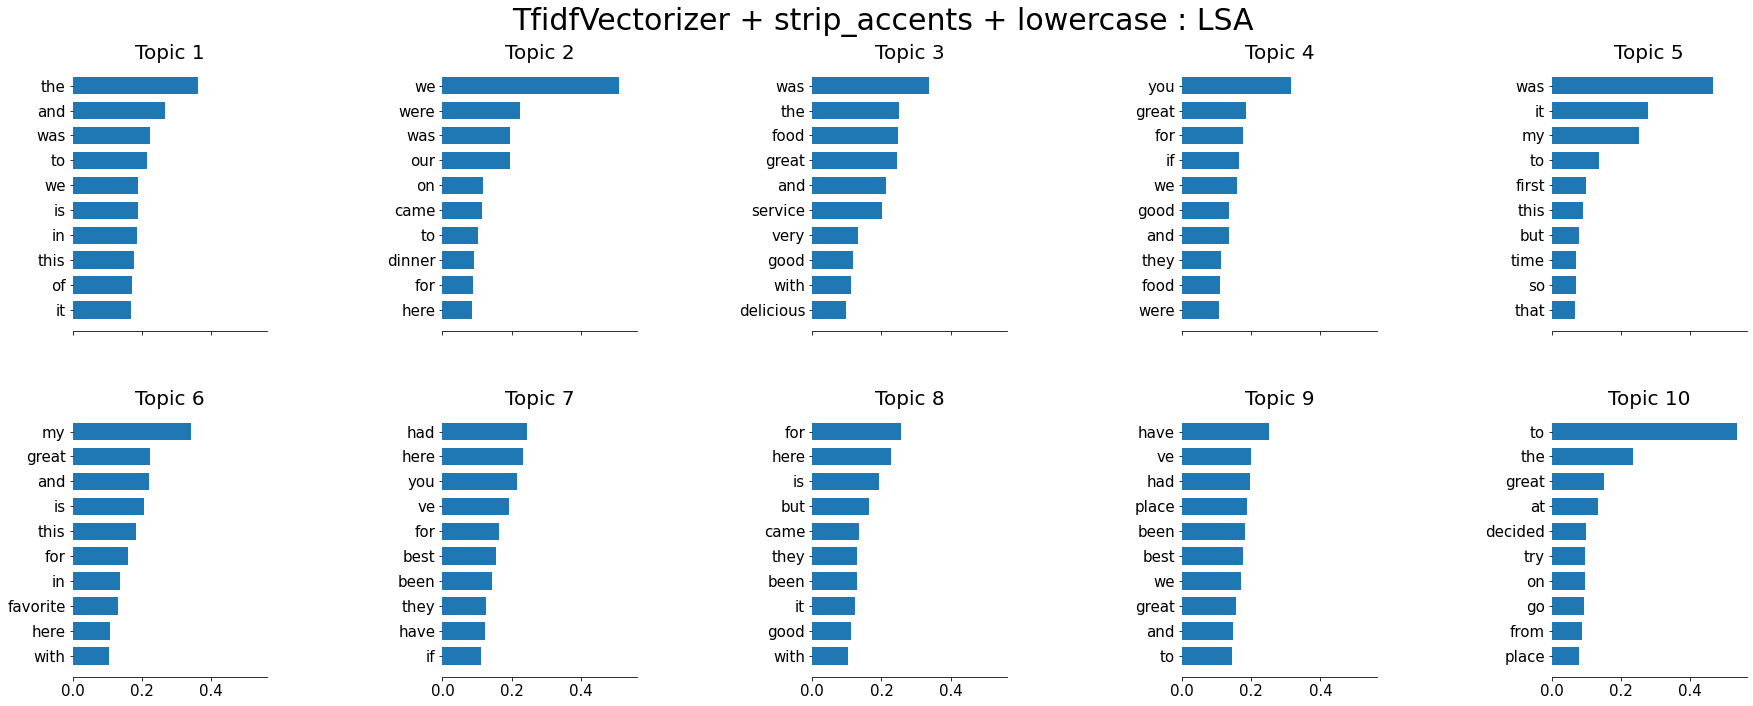

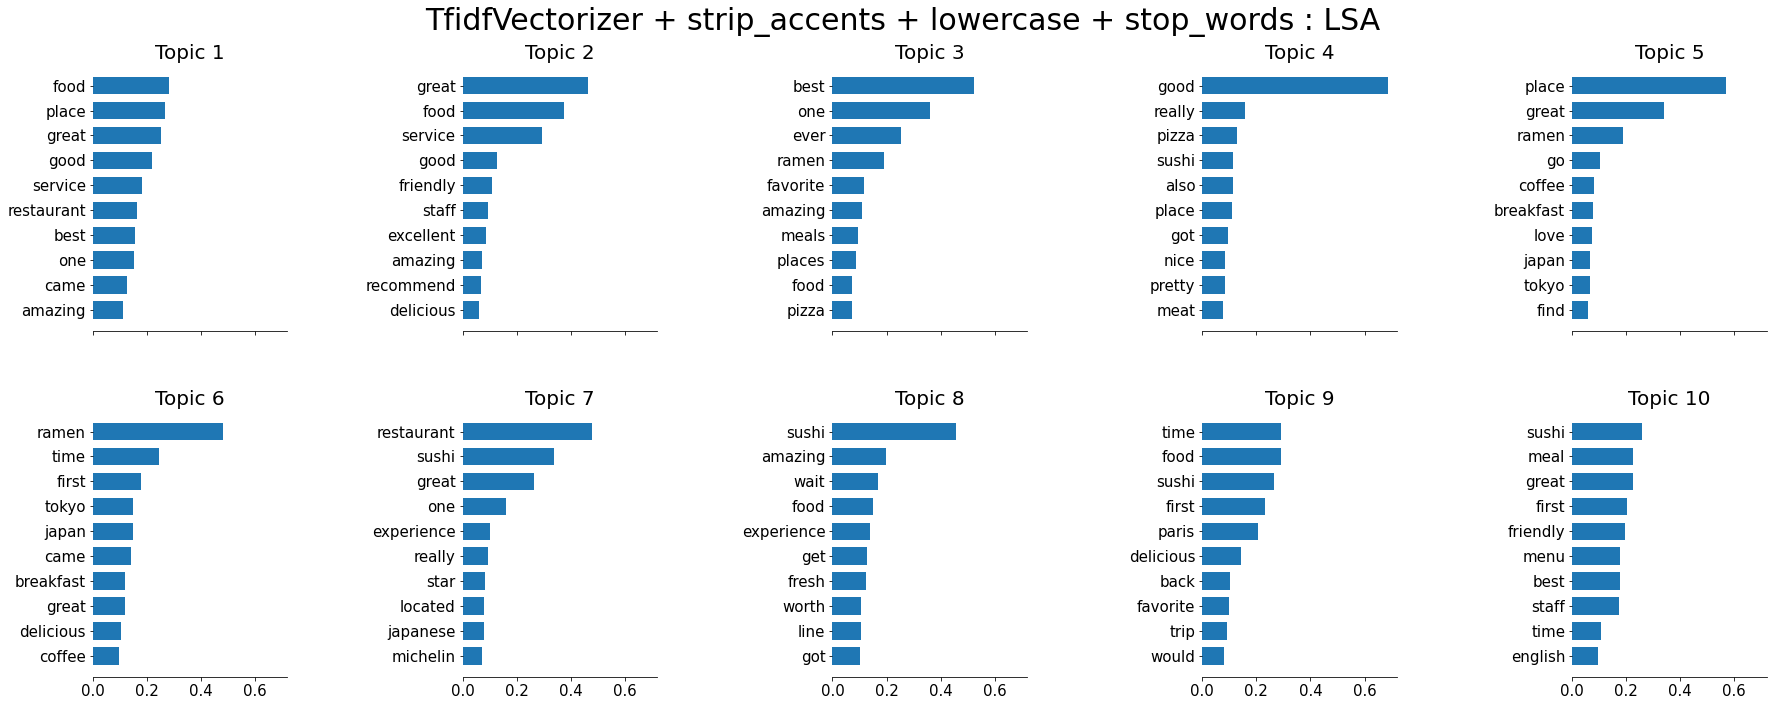

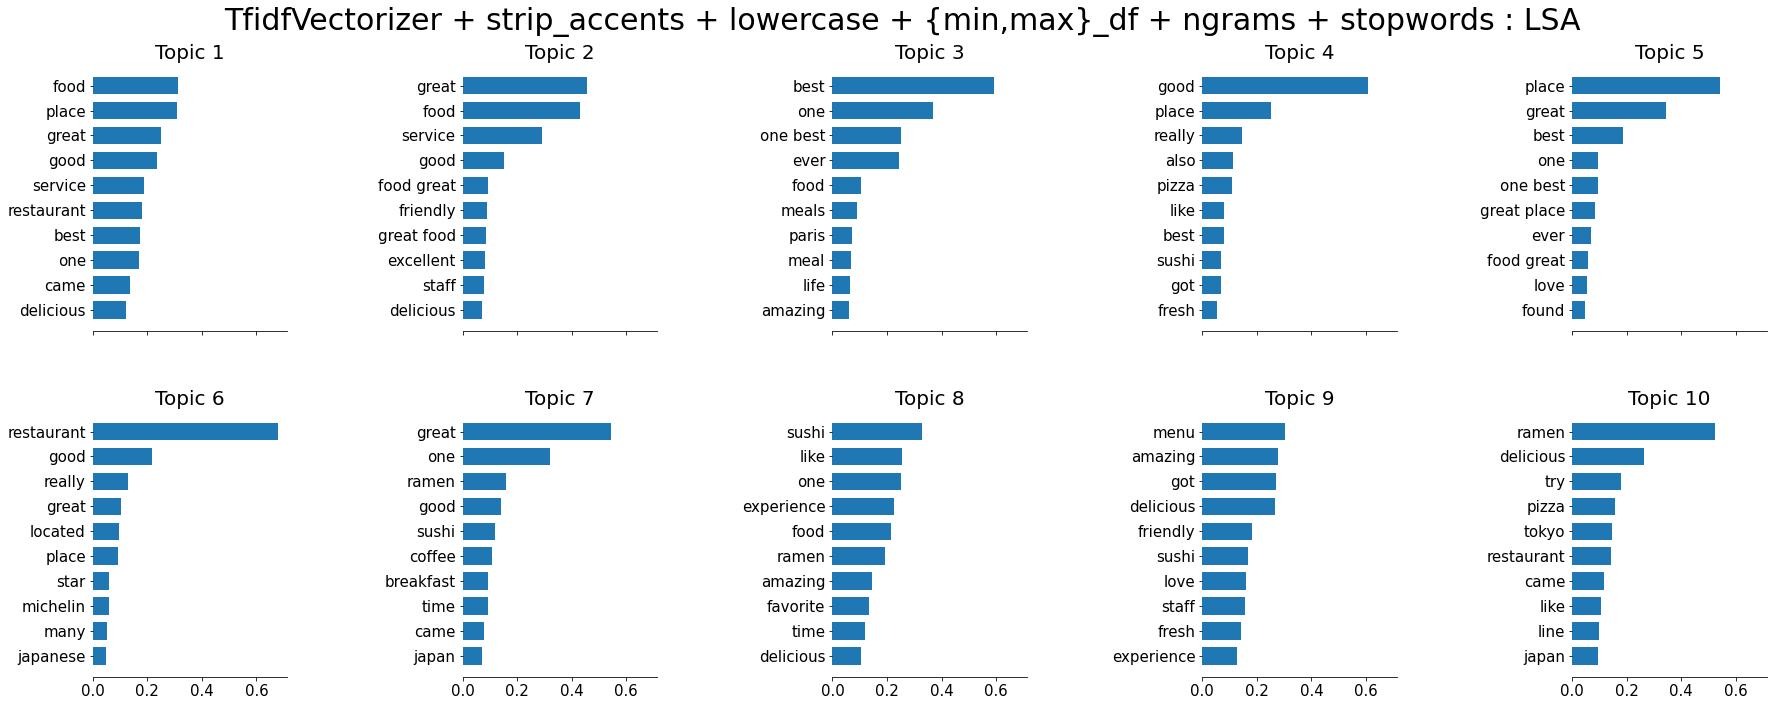

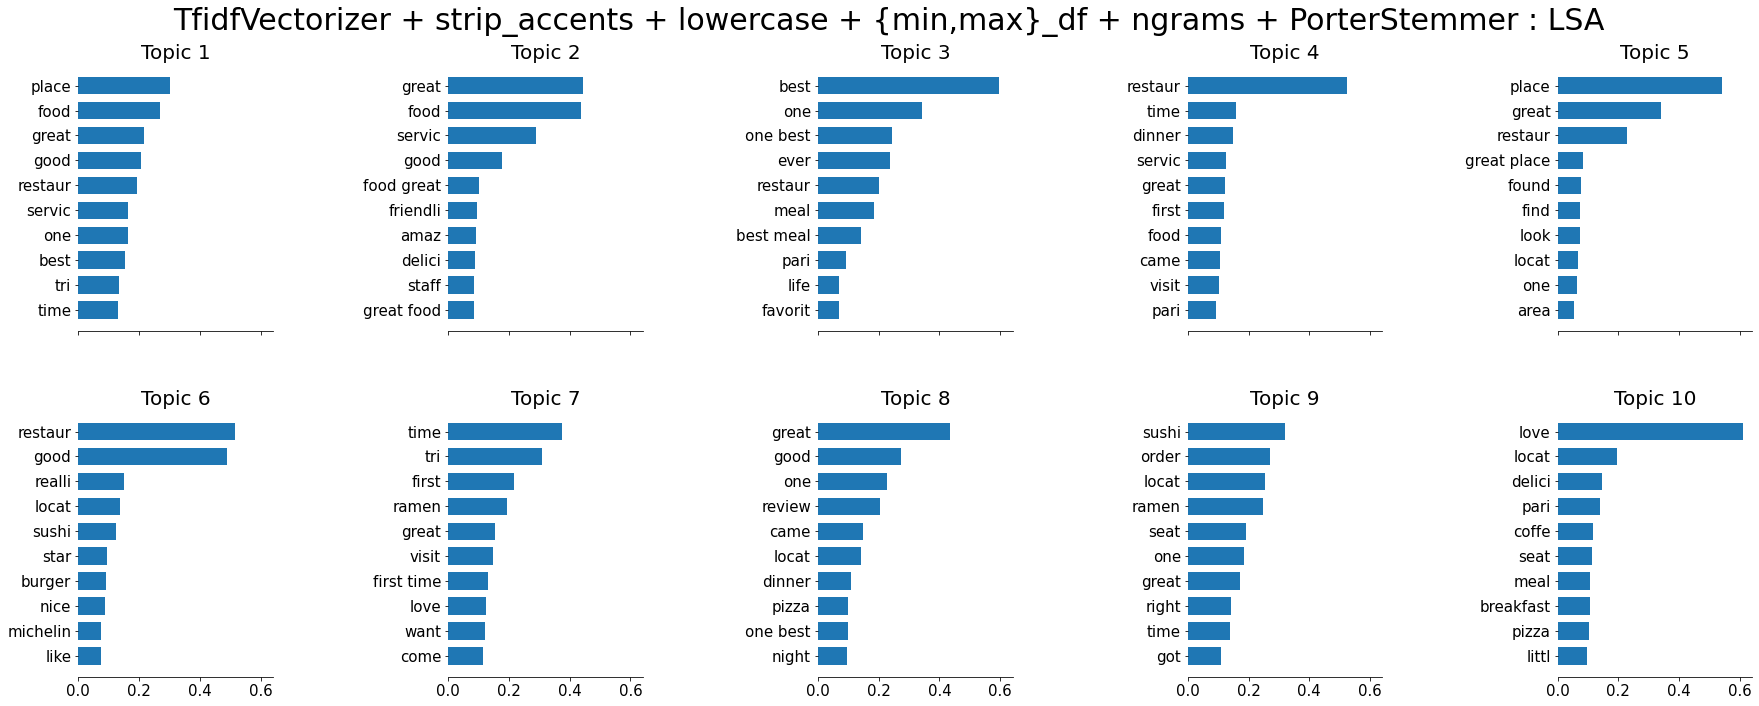

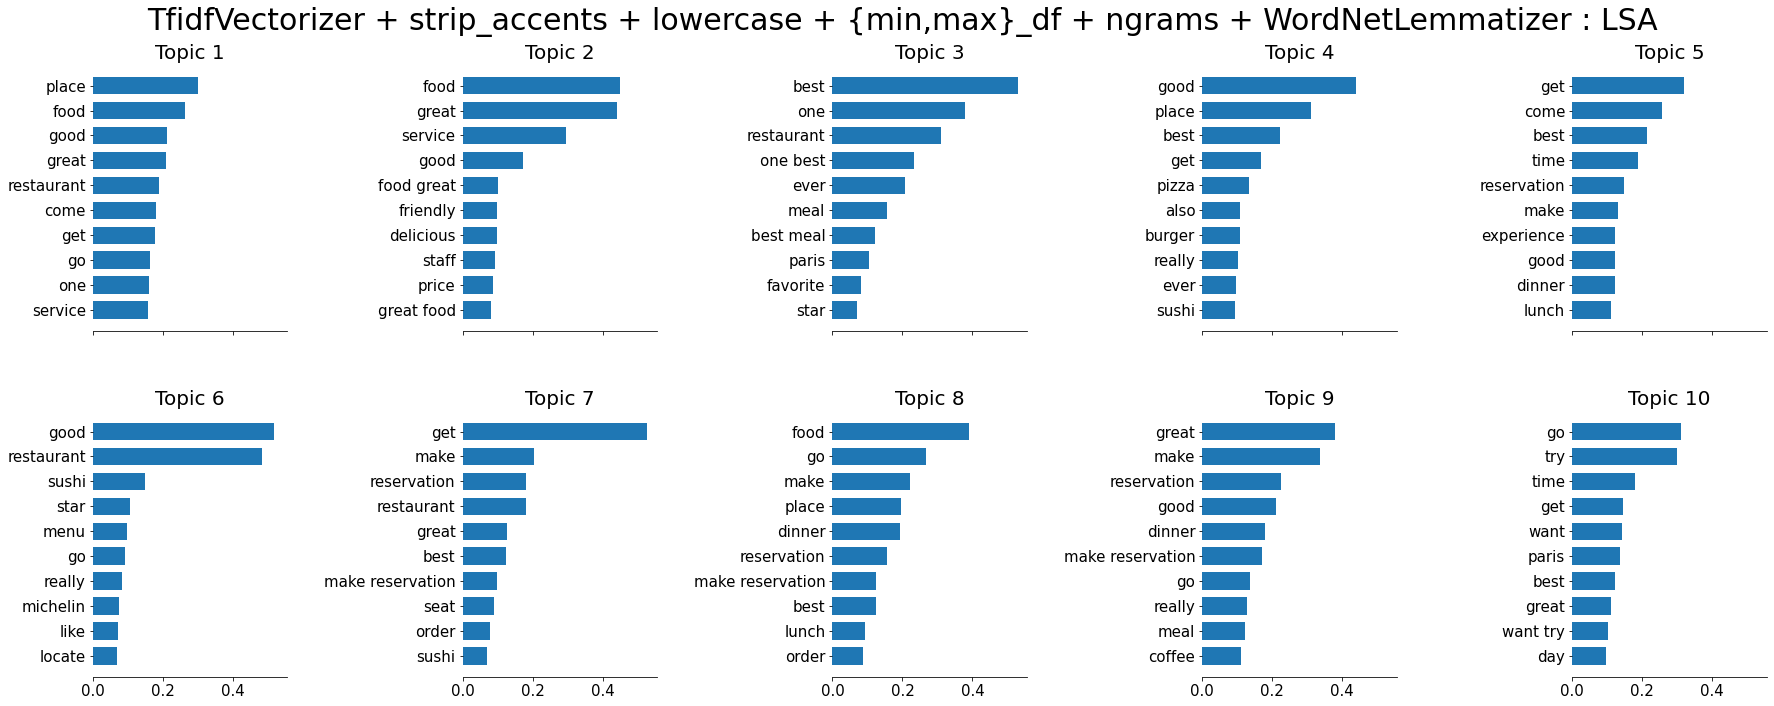

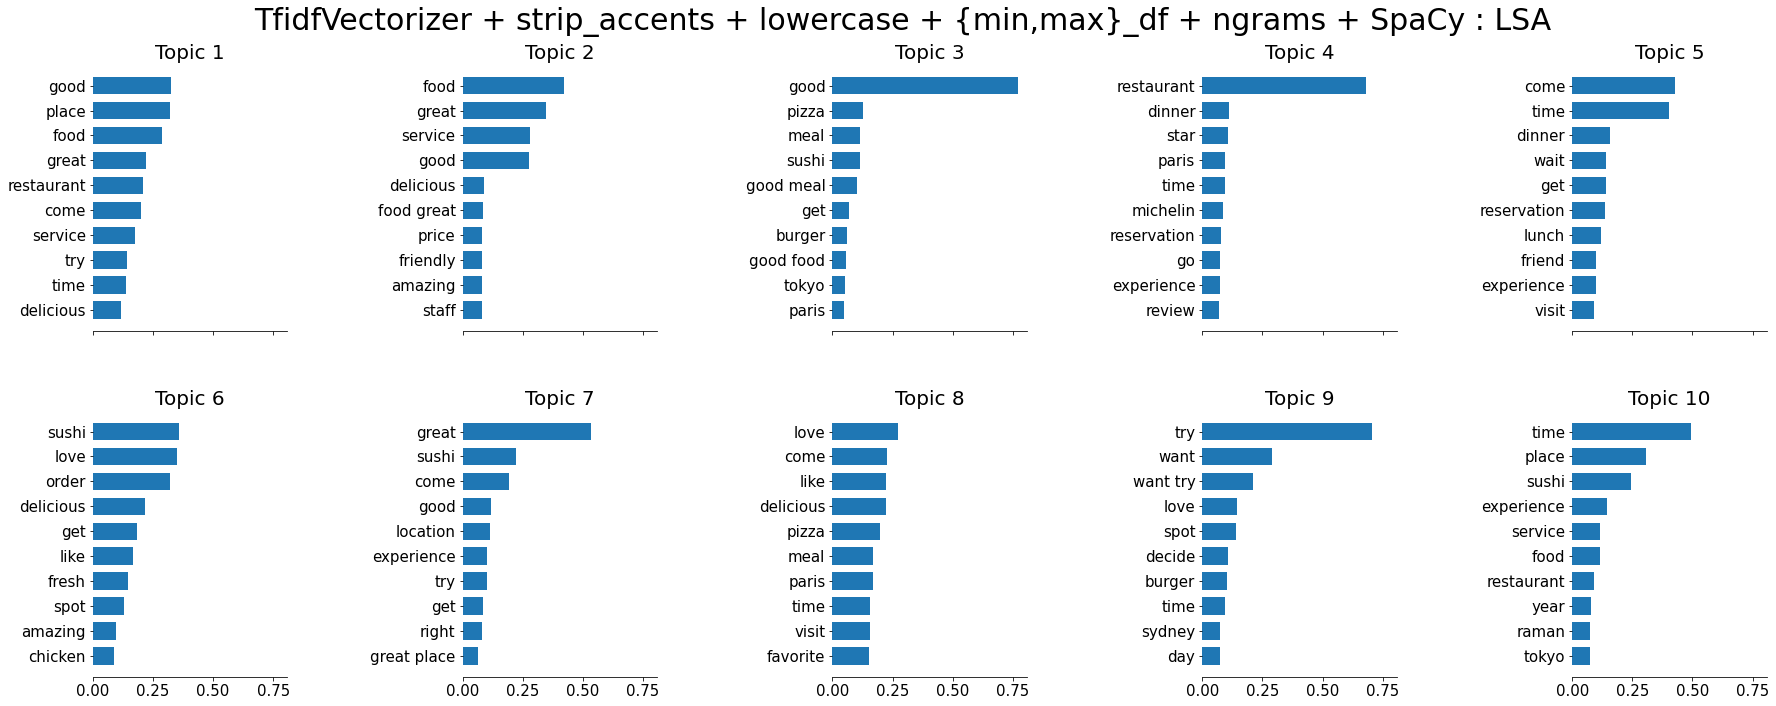

In [34]:
from sklearn.decomposition import TruncatedSVD


# Test different vectorizers
for vectorizer_name in [
    "TfidfVectorizer + strip_accents + lowercase",
    "TfidfVectorizer + strip_accents + lowercase + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + stopwords",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + PorterStemmer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + WordNetLemmatizer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy",
]:
    # Vectorize the corpus
    vectorizer = vectorizers[vectorizer_name]
    X_vec = vectorizer.fit_transform(X)

    # Project the documents into the latent space (10 topics)
    lsa = TruncatedSVD(n_components=10, random_state=42)
    X_lsa = lsa.fit_transform(X_vec)

    # Plot the top words of each topic
    viz_helpers.plot_top_words(
        model=lsa,
        feature_names=vectorizer.get_feature_names_out(),
        n_top_words=10,
        n_topics=10,
        title=f"{vectorizer_name} : LSA",
    )

As we can see, the more complex the vectorizers and tokenizers, the more meaningful the topics.

Here, we can identify the following topics :

-   Topic 2 : service-related words ("service", "price", "friendly", "staff", ...)
-   Topic 3 : different kinds of fast food ("pizza", "sushi", "burger", ...)
-   Topic 4 : Parisian Michelin stared restaurants ("dinner", "star", "paris", "michelin", ...)
-   Topic 5 : time-related words ("time", "wait", "reservation", ...)
-   Topic 10 : Japanese restaurants ("sushi", "raman", "tokyo", ...)


##### Academic dataset

Now let's observe the topics on the Academic dataset.

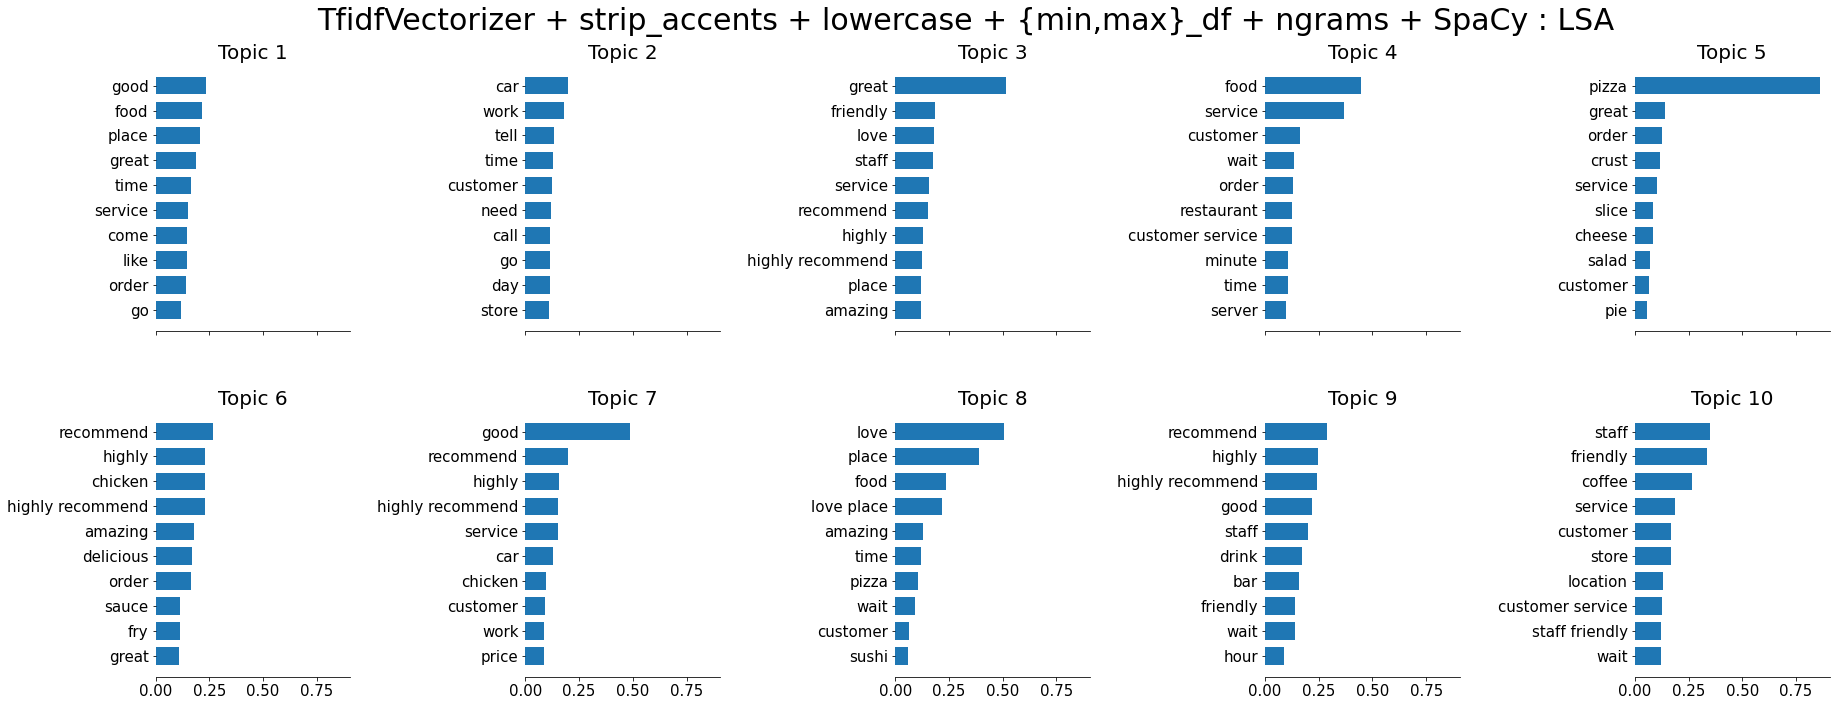

In [35]:
from sklearn.decomposition import TruncatedSVD


# Vectorize the corpus
vectorizer = vectorizers[
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy"
]
X_vec = vectorizer.fit_transform(X_academic)

# Project the documents into the latent space (10 topics)
lsa = TruncatedSVD(n_components=10, random_state=42)
X_lsa = lsa.fit_transform(X_vec)

# Plot the top words of each topic
viz_helpers.plot_top_words(
    model=lsa,
    feature_names=vectorizer.get_feature_names_out(),
    n_top_words=10,
    n_topics=10,
    title=f"{vectorizer_name} : LSA",
)

As we can see, the topics seem well defined. 

Here, we can identify the following topics :

-   Topic 3 and 10 : service-related words ("service", "friendly", "staff", ...)
-   Topic 4 : time-related words ("time", "wait", "minute", ...)
-   Topic 5 : pizza-related terms ("pizza", "crust", "sliec", ...)
-   Topic 6 : recommandations ("highly recommend", "amazing", "delicious", ...)
-   ...


#### Latent Dirichlet Allocation (LDA)

We are now going to use the Latent Dirichlet Allocation (LDA) technique to identify the topics of the reviews.

We are going to use the most complex vectorizer and tokenizer, in order to have really meaningful topics.

This technique has a hyperparameter that defines the number of topics to be identified, so we want to find the best number of topics. For this, we are first going to compute the perplexity and coherence of the model for different number of topics.

##### API dataset

First, let's run the LDA model on the API dataset.

In [36]:
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary


# Build the tokenized corpus
docs = X.map(tokenizers["SpaCy"])
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# We already know the best number of topics
num_topics = 35

# If we don't know it, we can use the following function to find it
if not num_topics > 0:
    # Compute the perplexity and coherence scores of the LDA model for diffenrent number of topics
    results_lda = []
    for num_topics in range(2, 80, 5):
        # Build the LDA model
        lda = LdaModel(
            corpus=corpus_tfidf,
            id2word=dictionary,
            num_topics=num_topics,
            per_word_topics=True,
            passes=10,
            random_state=42,
        )

        # Compute the scores
        results = {
            "num_topics": num_topics,
            "perplexity": lda.log_perplexity(
                corpus
            ),  # Compute Perplexity (lower is better)
            "coherence": CoherenceModel(
                lda, texts=docs
            ).get_coherence(),  # Compute Coherence Score (higher is better)
        }
        results_lda.append(results)

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(  # Plot perplexity
            x=pd.DataFrame(results_lda)["num_topics"],
            y=pd.DataFrame(results_lda)["perplexity"],
            name="Perplexity",
            mode="lines",
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(  # Plot coherence
            x=pd.DataFrame(results_lda)["num_topics"],
            y=pd.DataFrame(results_lda)["coherence"],
            name="Coherence",
            mode="lines",
        ),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="LDA Coherence and Perplexity",
        xaxis_title="Number of Topics",
        yaxis_title="Perplexity",
        yaxis2_title="Coherence",
    )
    fig.show()

We can see that the optimal number of topics seems to be is 35. With more than 60 topics, we have artifacts due to maximum possible topics.
Now let's observe the topics.


In [37]:
import pyLDAvis
import pyLDAvis.gensim_models


pyLDAvis.enable_notebook()

lda = LdaModel(
    corpus=corpus_tfidf,
    id2word=dictionary,
    num_topics=num_topics,
    per_word_topics=True,
    passes=10,
    random_state=42,
)

pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the m

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.141358  0.056176       1        1  7.358884
31     0.131470  0.011917       2        1  6.398422
26     0.106977 -0.019671       3        1  5.672937
21     0.077632  0.154853       4        1  4.833811
30     0.067275 -0.056190       5        1  4.444204
1      0.083528 -0.083942       6        1  4.434548
8      0.090903 -0.026554       7        1  4.324805
13     0.082846 -0.032231       8        1  4.110452
7      0.071057  0.018258       9        1  4.010904
22     0.060817 -0.025059      10        1  3.838393
0      0.075469 -0.023078      11        1  3.603049
19     0.029989  0.014600      12        1  3.473949
25     0.021370  0.064401      13        1  3.472553
3      0.048629 -0.004839      14        1  3.472286
23     0.039515  0.027464      15        1  3.337990
12     0.041520  0.043362      16        1  3.248947
18     0.000914  0.098464      17        1  2.596893
32    -0.026010 -0.040957      18        1  2.483156
11     0.004262 -0.106537      19        1  2.334809
34     0.003872 -0.081389      20        1  2.242690
6     -0.024768 -0.069529      21        1  2.052608
10    -0.048870 -0.041719      22        1  1.725653
14    -0.043623 -0.022584      23        1  1.610050
2     -0.027385  0.031120      24        1  1.599373
4     -0.079216  0.003503      25        1  1.597733
27    -0.035336  0.010260      26        1  1.543283
33    -0.069470  0.026628      27        1  1.458754
16    -0.102869  0.016351      28        1  1.371989
17    -0.113803  0.006481      29        1  1.287045
29    -0.115139  0.004036      30        1  1.123815
28    -0.098872 -0.002207      31        1  1.115993
9     -0.090389  0.018044      32        1  1.067821
20    -0.080913 -0.000985      33        1  1.020452
24    -0.106090  0.005939      34        1  0.936691
5     -0.116651  0.025616      35        1  0.795059, topic_info=           Term       Freq      Total Category  logprob  loglift
572        view  63.000000  63.000000  Default  30.0000  30.0000
594      coffee  79.000000  79.000000  Default  29.0000  29.0000
1290      raman  60.000000  60.000000  Default  28.0000  28.0000
619        tell  29.000000  29.000000  Default  27.0000  27.0000
179       local  38.000000  38.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
2609    manager   1.181710  13.417268  Topic35  -5.5170   2.4049
739   expensive   0.977735  17.064844  Topic35  -5.7065   1.9750
412      salmon   1.111175  25.747759  Topic35  -5.5786   1.6916
248   breakfast   1.498402  76.976490  Topic35  -5.2796   0.8954
183        walk   1.187137  72.449437  Topic35  -5.5124   0.7232

[1664 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
642       4  0.648318   ability
286       3  0.318923      able
286       4  0.550867      able
286      12  0.057986      able
549      12  0.149431  absolute
...     ...       ...       ...
224       9  0.862852       yum
224      26  0.033187       yum
225       5  0.216199     yummy
225      33  0.648598     yummy
3459     19  0.666334      zero

[3954 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 32, 27, 22, 31, 2, 9, 14, 8, 23, 1, 20, 26, 4, 24, 13, 19, 33, 12, 35, 7, 11, 15, 3, 5, 28, 34, 17, 18, 30, 29, 10, 21, 25, 6])

With this technique, we can identify the following topics :

-   Topic 1 : Japanese restaurants ("raman", "ramen", "japan", "tokyo", "ichiran", ...)
-   Topic 2 : Brazilian restaurants ("brazil", "feijoada", "janeiro", "rio", ...)
-   Topic 4 : negative words ("leave", "immediately", "unfortunately", "old", "ridiculous", ...)
-   Topic 7 : negative words ("decent", "mediocre", "budget", "despite", "not", "horrible", "overhype", ...)
-   Topic 10 : probably vegetarian restaurants ("vegetarian", "veggie", ...)
-   Topic 12 : probably related to the place ("outside", "inside", "sit", "pack", "place", ...)
-   Topic 15 : breakfast or brunch places ("toast", "egg", "pancake", ...)
-   ...

This technique is quite efficient and helps us to identify the topics of the reviews.


##### Academic dataset

Now let's compare with the Academic dataset.

In [38]:
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary


# Build the tokenized corpus
docs_academic = X_academic.map(tokenizers["SpaCy"])
dictionary_academic = Dictionary(docs_academic)
corpus_academic = [dictionary_academic.doc2bow(doc) for doc in docs_academic]
tfidf_academic = TfidfModel(corpus_academic, normalize=True)
corpus_tfidf_academic = tfidf_academic[corpus_academic]

# We already know the best number of topics
num_topics = 10

# If we don't know it, we can use the following function to find it
if not num_topics > 0:
    # Compute the perplexity and coherence scores of the LDA model for diffenrent number of topics
    results_lda = []
    for num_topics in range(2, 80, 5):
        # Build the LDA model
        lda = LdaModel(
            corpus=corpus_tfidf_academic,
            id2word=dictionary_academic,
            num_topics=num_topics,
            per_word_topics=True,
            passes=10,
            random_state=42,
        )

        # Compute the scores
        results = {
            "num_topics": num_topics,
            "perplexity": lda.log_perplexity(
                corpus
            ),  # Compute Perplexity (lower is better)
            "coherence": CoherenceModel(
                lda, texts=docs
            ).get_coherence(),  # Compute Coherence Score (higher is better)
        }
        results_lda.append(results)

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(  # Plot perplexity
            x=pd.DataFrame(results_lda)["num_topics"],
            y=pd.DataFrame(results_lda)["perplexity"],
            name="Perplexity",
            mode="lines",
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(  # Plot coherence
            x=pd.DataFrame(results_lda)["num_topics"],
            y=pd.DataFrame(results_lda)["coherence"],
            name="Coherence",
            mode="lines",
        ),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="LDA Coherence and Perplexity",
        xaxis_title="Number of Topics",
        yaxis_title="Perplexity",
        yaxis2_title="Coherence",
    )
    fig.show()

In [39]:
import pyLDAvis
import pyLDAvis.gensim_models


pyLDAvis.enable_notebook()

lda_academic = LdaModel(
    corpus=corpus_tfidf_academic,
    id2word=dictionary_academic,
    num_topics=35,
    per_word_topics=True,
    passes=10,
    random_state=42,
)

pyLDAvis.gensim_models.prepare(lda_academic, corpus_tfidf_academic, dictionary_academic)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.468206  0.137631       1        1  37.558467
24     0.441248  0.049787       2        1  18.807205
5      0.250273 -0.236084       3        1   7.461943
26     0.047818 -0.231019       4        1   3.587368
20    -0.003101 -0.074328       5        1   2.423005
22    -0.014605 -0.051530       6        1   2.139710
16    -0.028629 -0.016563       7        1   1.880032
17    -0.033312 -0.003777       8        1   1.688710
18    -0.040943  0.012469       9        1   1.347421
1     -0.041304  0.014451      10        1   1.278450
27    -0.041855  0.012128      11        1   1.258002
9     -0.044169  0.021047      12        1   1.104331
2     -0.040205  0.018333      13        1   1.040957
0     -0.042043  0.018033      14        1   1.013439
13    -0.043113  0.021974      15        1   1.002254
6     -0.044045  0.019612      16        1   0.989836
8     -0.042383  0.018749      17        1   0.923355
14    -0.043169  0.019513      18        1   0.919650
23    -0.041668  0.016168      19        1   0.875717
32    -0.042415  0.016018      20        1   0.875444
12    -0.042171  0.015693      21        1   0.852669
33    -0.042472  0.015987      22        1   0.834568
30    -0.041504  0.014553      23        1   0.834319
3     -0.042250  0.016293      24        1   0.831458
10    -0.042161  0.015953      25        1   0.831120
34    -0.042306  0.017210      26        1   0.827369
31    -0.042007  0.016557      27        1   0.815313
4     -0.041719  0.015969      28        1   0.799073
11    -0.041112  0.013730      29        1   0.772737
25    -0.041117  0.014504      30        1   0.770166
28    -0.040929  0.013458      31        1   0.765060
21    -0.040817  0.013123      32        1   0.746758
19    -0.039975  0.011425      33        1   0.720986
15    -0.040065  0.011519      34        1   0.712277
29    -0.039979  0.011414      35        1   0.710830, topic_info=           Term        Freq       Total Category  logprob  loglift
33      chicken  101.000000  101.000000  Default  30.0000  30.0000
553         bbq   29.000000   29.000000  Default  29.0000  29.0000
17         food  195.000000  195.000000  Default  28.0000  28.0000
514        nail   35.000000   35.000000  Default  27.0000  27.0000
507         dog   33.000000   33.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
8388    someday    0.643727    1.249494  Topic35  -6.3287   4.2833
5978     helmet    0.636416    1.242182  Topic35  -6.3401   4.2777
6338  shellfish    0.631595    1.237362  Topic35  -6.3477   4.2740
5323   balsamic    0.616646    1.222413  Topic35  -6.3717   4.2622
2755      italy    0.924422    1.845001  Topic35  -5.9668   4.2554

[1406 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5227      7  0.921849    acceptable
2817     11  0.274822        access
2817     28  0.549644        access
4031     11  0.651747      accident
502      27  0.517289  accidentally
...     ...       ...           ...
1056      2  0.956243           yum
1504      2  0.920846         yummy
1504      4  0.040037         yummy
2300     33  0.676492           zen
2917     17  0.825151          zone

[1828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 25, 6, 27, 21, 23, 17, 18, 19, 2, 28, 10, 3, 1, 14, 7, 9, 15, 24, 33, 13, 34, 31, 4, 11, 35, 32, 5, 12, 26, 29, 22, 20, 16, 30])

Here, we can identify the following topics :

-   Topic 1 : time-related words ("time", "minute", "wait", "hour", ...)
-   Topic 2 : food-related words ("burger", "chicken", "fry", ...)
-   Topic 3 : environment-related words ("space", "music", "convenient", ...)
-   Topic 4 : animal or baby -related words ("dog", "pet", "baby", ...)
-   ...

This technique is quite efficient and helps us to identify the topics of the reviews.


### Word Embedding

The bag of words representation that we have used until now doesn't capture the similarity between words. For that, we can use **word embeddings** to represent words as vectors, so that synonyms have a similar representation. Word embedding is a technique that represents words according to their context.


#### Word2Vec

Let's use the `Word2Vec` model to represent words as vectors.

In [40]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(docs)
word2vec.wv.most_similar(["burger"], topn=10)

[('french', 0.999680757522583),
 ('good', 0.9996775984764099),
 ('come', 0.9996712803840637),
 ('quality', 0.9996622800827026),
 ('meat', 0.9996610879898071),
 ('area', 0.9996607303619385),
 ('order', 0.9996595978736877),
 ('get', 0.9996592402458191),
 ('look', 0.9996525645256042),
 ('cheese', 0.9996507167816162)]

We want to find a word that would be similar to the word "burger". Our model is not very good at finding similar words, but we can see that the word "burger" is similar to the words "meat", "cheese", "fry".


In [41]:
from gensim.models.word2vec import Word2Vec


word2vec_academic = Word2Vec(docs_academic)
word2vec_academic.wv.most_similar(["burger"], topn=10)

[('wing', 0.9725143313407898),
 ('sandwich', 0.9572331309318542),
 ('taco', 0.9523965120315552),
 ('steak', 0.9500656723976135),
 ('oyster', 0.9226208925247192),
 ('chicken', 0.9205889701843262),
 ('soup', 0.9165077805519104),
 ('burrito', 0.9161268472671509),
 ('entree', 0.9127262830734253),
 ('sub', 0.9116759896278381)]

We can see that the similar words are more relevant with a better dataset.

In [42]:
from sklearn.manifold import TSNE


X_w2v = [word2vec_academic.wv[x] for x in word2vec_academic.wv.key_to_index.keys()]
X_tsne = TSNE(random_state=42, n_jobs=-1).fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=word2vec_academic.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="Word2Vec TSNE",
)
fig.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


If we zoom-in on a zone, we can see that similar words are close to each other.

#### FastText

Let's use the `FastText` model to represent words as vectors.

In [43]:
from gensim.models.fasttext import FastText


fasttext = FastText(docs)
fasttext.wv.most_similar(["burger"], topn=10)

[('lovely', 0.9999839067459106),
 ('order', 0.9999837279319763),
 ('water', 0.9999833106994629),
 ('typically', 0.999983012676239),
 ('specifically', 0.9999829530715942),
 ('butter', 0.9999828338623047),
 ('diner', 0.9999828338623047),
 ('fantastic', 0.9999823570251465),
 ('consider', 0.9999821186065674),
 ('creative', 0.9999819397926331)]

We want to find a word that would be similar to the word "burger". Our model is not very good at finding similar words.


In [44]:
from gensim.models.fasttext import FastText


fasttext_academic = FastText(docs_academic)
fasttext_academic.wv.most_similar(["burger"], topn=10)

[('hamburger', 0.9784219264984131),
 ('salad', 0.9774818420410156),
 ('sandwich', 0.9728217124938965),
 ('cheeseburger', 0.9653225541114807),
 ('sandwhich', 0.9630533456802368),
 ('steak', 0.957073450088501),
 ('tacos', 0.9561993479728699),
 ('bread', 0.9551296234130859),
 ('grill', 0.954938530921936),
 ('chick', 0.9545977115631104)]

We can see that the similar words are more relevant with a better dataset.

In [45]:
from sklearn.manifold import TSNE


X_ft = [fasttext_academic.wv[x] for x in fasttext_academic.wv.key_to_index.keys()]
X_tsne = TSNE(random_state=42, n_jobs=-1).fit_transform(X_ft)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=fasttext_academic.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="FastText TSNE",
)
fig.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


Again, if we zoom-in on a zone, we can see that similar words are close to each other.